In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

# To import h and normalize the mass
import pyTNG.cosmology as _cosmo
h = _cosmo.TNGcosmo.h

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
import illustris_python as il

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [17]:
def get_median_escape(df, edges, mass_type, mode='mean', f_esc_loc=1.0):
    medians = []
    error = []
    for i in range(len(edges)-1):
        sub_df = df[(edges[i]*(1-1e-10)<df[mass_type]) & (df[mass_type]<edges[i+1])]
        sub_esc = sub_df['Q0']*sub_df['f_esc']*f_esc_loc
        if mode == 'median':
            medians.append(sub_esc.median())
        elif mode == 'mean':
            medians.append(sub_esc.mean())
        error.append(sub_esc.std()/np.sqrt(len(sub_esc)))
#         root_n = np.sqrt(len(sub_esc)) 
#         std = sub_esc.std()
#         median = sub_esc.median()
    return np.array(medians), np.array(error)

def get_tng_masses(mass_type, snap):
    basePath = '/virgo/simulations/IllustrisTNG/L35n2160TNG/output'
    if mass_type == 'StarMass':
        masses = il.groupcat.loadHalos(basePath,snap,fields='GroupMassType')[:,4]/h
    elif mass_type == 'HaloMass':
        masses = il.groupcat.loadHalos(basePath,snap,fields='GroupMass')/h
    else:
        raise ValueError(f'"mass_type" has to be "StarMass" or "GroupMass" received {mass_type} instead')
    return masses

def get_esc_dens(df, redshift, bins, mode='mean', mass_type='StarMass'):
    redshift_map = {6:13, 8:8, 10:4}
    box_size=35.
    tng_masses = get_tng_masses(mass_type, snap=redshift_map[redshift])
    
    mass_min = tng_masses[tng_masses!=0].min()
    mass_max = tng_masses.max()
    edges = np.logspace(np.log10(mass_min),np.log10(mass_max), bins)
    
    centroids = []
    widths = []
    for i in range(len(edges)-1):
        centroids.append(edges[i]/2+edges[i+1]/2)
        widths.append(edges[i+1]-edges[i])
    centroids = np.array(centroids)
    widths = np.array(widths)
    hist, _ = np.histogram(tng_masses, bins=edges)
    hist_norm = hist/box_size**3
    
    median_esc, esc_err = get_median_escape(df[df.z==redshift], edges, mass_type,  mode='mean')
    dens_esc = median_esc*hist_norm
    dens_err = esc_err*hist_norm
    
    hist_used = hist_norm[np.logical_not(np.isnan(median_esc))]
    centroids_used = centroids[np.logical_not(np.isnan(median_esc))]
    widths_used = widths[np.logical_not(np.isnan(median_esc))]
    
    used = [centroids_used, hist_used, widths_used]
    all_hist = [centroids, hist_norm, widths]
    uv_escape = [centroids, dens_esc, dens_err, widths_used]
    return used, all_hist, uv_escape

In [4]:
def plot_esc_dens(df, redshift=6, bins=50, mass_type='StarMass', save=False):
    used, all_hist, uv_escape = get_esc_dens(df, redshift=redshift, bins=bins, mass_type=mass_type)
    if mass_type == 'StarMass':
        mult = 1e10
        x_label = '$\log(M_\mathrm{star})[M_\mathrm{sun}]$'
    elif mass_type == 'HaloMass':
        mult = 1e10
        x_label = '$\log(M_\mathrm{halo})[M_\mathrm{sun}]$'
        
    fig, ax1 = plt.subplots()
    fig.suptitle(f'z={redshift}', fontsize=30)

    x_used = np.log10(np.array(used[0])*mult)
    x_all = np.log10(np.array(all_hist[0])*mult)
    width = x_used[1]-x_used[0]
    ax1.bar(x_all, all_hist[1], width=width, label='all halos')#, width=np.log10(np.array(all_hist[2])*mult))
    ax1.bar(x_used, used[1], width=width, label='halos used in simulations')#, width=np.log10(np.array(used[2])*mult))
    ax1.tick_params(length=10, width=3)
    ax1.tick_params(length=5, width=2, which='minor')
    ax1.set_yscale('log')
    ax1.set_ylabel('$n_\mathrm{clusters}[\mathrm{cMpc}^{-3}]$', size=45)
    ax1.set_xlabel(x_label, size=45)
    ax1.set_xlim(5.0,9.5)
    ax1.legend(fontsize=35)
    plt.rc('axes', linewidth=2)
    matplotlib.rc('xtick', labelsize=25) 
    matplotlib.rc('ytick', labelsize=25) 
    plt.rcParams["figure.figsize"] = (15,15)
    
    if save:
        path = f'/u/ivkos/analysis/plots/halo_density_z{redshift}.pdf'
        plt.savefig(path)
    
#     ax2 = ax1.twinx()
#     ax2.errorbar(uv_escape[0], uv_escape[1], yerr=uv_escape[2], linewidth=3, elinewidth=1, capsize=10, color='black')
#     ax2.tick_params(length=10, width=3)
#     ax2.tick_params(length=5, width=2, which='minor')
#     ax2.set_yscale('log')
#     ax2.set_ylabel('$N_\gamma[s^{-1}\mathrm{cMpc}^{-3}]$', size=30);
    return

In [50]:
def plot_z_esc(df, redshifts=[6,8,10], bins=50, mass_type='StarMass', cumulative=False, lower_ylim=49, upper_ylim=52, save=False):
    
    labelsize = 60
    ticksize = 45
    linewidth = 5
    errorwidth = 3
    capsize = 10
    legendsize = 50
    axes_width = 3
    plot_width = 25
    plot_height = 20
    major_tick_length = 10
    major_tick_width = 3
    minor_tick_length = 5
    minor_tick_width = 2
    
    fig_width = 20
    fig_height = 25
    
    cutoff_halo_mass = 25
    
    lower_ylim = lower_ylim
    upper_ylim = upper_ylim
    fig, ax1 = plt.subplots()
    
    if mass_type == 'StarMass':
        mult = 1e10
        x_label = '$\log(M_\mathrm{star})[M_\mathrm{sun}]$'
    elif mass_type == 'HaloMass':
        mult = 1e10
        x_label = '$\log(M_\mathrm{halo})[M_\mathrm{sun}]$'
    
    for redshift in redshifts:
        _, _, uv_esc = get_esc_dens(df, redshift=redshift, bins=bins, mass_type=mass_type)
        
        escaped_photons = np.array(uv_esc[1])
        escaped_error = uv_esc[2]
        widths_used = uv_esc[3]
        if cumulative:
            cumulative_values = []
            cumulative_error = []
            summed_value = 0
            for j,element in enumerate(escaped_photons):
                if np.isnan(element):
                    element = 0
                # Hack to ignore first few values with large errorbars
                if mass_type == 'HaloMass':
                    if j < cutoff_halo_mass:
                        continue
                summed_value += element
                summed_error = np.sqrt(np.nansum(np.square(escaped_error[:j+1])))
                cumulative_values.append(summed_value)
                cumulative_error.append(summed_error)
            escaped_photons = np.array(cumulative_values)
            escaped_error = np.array(cumulative_error)
            
        escaped_uv = np.log10(escaped_photons)
        err_uv = escaped_error/(np.log(10)*escaped_photons)
        if cumulative:
            if mass_type == 'HaloMass':
                uv_esc[0] = uv_esc[0][cutoff_halo_mass:]
            ax1.plot(np.log10(np.array(uv_esc[0])*mult), escaped_uv, linewidth=linewidth, label=f'z={redshift}')
        else:
            if mass_type == 'HaloMass':
                uv_esc[0] = uv_esc[0][cutoff_halo_mass:]
                escaped_uv = escaped_uv[cutoff_halo_mass:]
                err_uv = err_uv[cutoff_halo_mass:]
            ax1.errorbar(np.log10(np.array(uv_esc[0])*mult), escaped_uv, yerr=err_uv, 
                         linewidth=linewidth, elinewidth=errorwidth, capsize=capsize, label=f'z={redshift}')
    
    ax1.set_ylim(lower_ylim, upper_ylim)
    if cumulative:
        y_label = r'$\log(\dot{N}_\mathrm{ion}(<M_*))[s^{-1}\mathrm{cMpc}^{-3}]$'
    else:
        y_label = r'$\log(\dot{N}_\mathrm{ion})[s^{-1}\mathrm{cMpc}^{-3}]$'
    ax1.set_ylabel(y_label, size=labelsize)
    ax1.set_xlabel(x_label, size=labelsize)
    ax1.legend(fontsize=legendsize)
    
    plt.rcParams["figure.figsize"] = (plot_width,plot_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=ticksize) 
    plt.rc('ytick', labelsize=ticksize) 
    plt.tick_params(length=major_tick_length, width=major_tick_width)
    plt.tick_params(length=minor_tick_length, width=minor_tick_width, which='minor')
    plt.rcParams["figure.figsize"] = (fig_width,fig_height)
    
    if save:
        if cumulative:
            appendix = 'cumulative'
        else:
            appendix = ''
        path = f'/u/ivkos/analysis/plots/uv_{mass_type}_{appendix}.pdf'
        plt.savefig(path, bbox_inches = 'tight')

In [6]:
def plot_uv_redshift(df, redshifts=[6,8,10], bins=50, mass_type='StarMass',log=False, save=False):
    tot_uv = []
    tot_uv_err = []
        
    for redshift in redshifts:
        _, _, uv_esc = get_esc_dens(df, redshift=redshift, bins=bins, mass_type=mass_type)
        tot_uv.append(np.sum(uv_esc[1][~np.isnan(uv_esc[1])]))
        err_not_nan = uv_esc[2][~np.isnan(uv_esc[2])]
        uv_err = np.sqrt(np.sum(np.square(np.array(err_not_nan))))
        tot_uv_err.append(uv_err)
        
    if log:
        y_label = r'$\log(\dot{N}_\mathrm{ion})[\mathrm{s}^{-1}\mathrm{cMpc}^{-3}]}$'
        uv_err = np.array(uv_err)/(np.log(10)*np.array(tot_uv))
        tot_uv = np.log10(np.array(tot_uv))
    else:
        y_label = r'$\dot{N}_\mathrm{ion}[\mathrm{s}^{-1}\mathrm{cMpc}^{-3}]}$'

    print(tot_uv)
    print(uv_err)
    plt.errorbar(redshifts, tot_uv, yerr=uv_err, marker='s', linewidth=3, elinewidth=1, capsize=10, markersize=25, linestyle='--')
    plt.rcParams["figure.figsize"] = (20,25)
    plt.rc('axes', linewidth=2)
    plt.rc('xtick', labelsize=35) 
    plt.rc('ytick', labelsize=35) 
    plt.tick_params(length=10, width=3)
    plt.tick_params(length=5, width=2, which='minor')
    
    plt.xlabel('z', size=45)
    plt.ylabel(y_label, size=45)
    if save:
        path = f'/u/ivkos/analysis/plots/uv_z.pdf'
        plt.savefig(path)

In [7]:
def plot_scatter_color(df, y_prop='Q0', y_label=None, save = False):

    redshifts = [6,8,10]
    for redshift in redshifts:
        sub_df = df[df.z==redshift]
        x_values = np.log10(np.array(sub_df['StarMass'])*1e6)
        y_values = np.log10(np.array(sub_df[y_prop]))
        plt.scatter(x_values, y_values, label=f'z={redshift}')
    
    x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    if y_label == None:
        y_label = y_prop
    else:
        y_label = y_label
            
    
    plt.xlabel(x_label, size=35)
    plt.ylabel(y_label, size=35)
    plt.tick_params(length=16, width=4)
    plt.tick_params(length=8, width=3, which='minor')
    plt.legend(fontsize=35)

    plt.rcParams["figure.figsize"] = (20,25)
    plt.rc('axes', linewidth=2)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
    plt.rcParams["figure.figsize"] = (20,20)
    
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/all_data_scatter.pdf')
    plt.show();
    return

In [8]:
def update_df(df, h=0.6774):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']/h
    df['HaloMass']= df['HaloMass']/h
    return

In [30]:
anderson_vulcan_z = [6,7,8,10]
anderson_vulcan_values = [50.85, 50.78, 50.6, 50.48]
anderson_vulcan_upper = [51.0, 51., 50.95, 50.9]
anderson_vulcan_lower = [50.5, 50.3, 49.9, 49.15]

bouwens_z = [6,7,8,9,10]
bouwens_upper = [51.15, 50.9, 50.7, 50.6, 50.5]
bouwens_lower = [50.7, 50.6, 50.5, 50.4, 50.1]

eide_z = [6,7,8,9,10]
eide_values = [51.2, 51., 51.2, 50.95, 50.9]

bouwens_2005_z = [7.5,10]
bouwens_2005_z_err = [1.,1.2]
bouwens_2005_values = [49.5,49.2]
bouwens_2005_upper = [49.7,49.2]
bouwens_2005_lower = [0,0]

richard_2006_z = [7.7,8.7]
richard_2006_z_err = [1.,2.]
richard_2006_values = [50.9,51.1]
richard_2006_upper = [50.9,51.1]
richard_2006_lower = [0,0]

stark_2007_z = [9.2]
stark_2007_z_err = [0.7]
stark_2007_values = [51.6]
stark_2007_upper = [51.6]
stark_2007_lower = [0]

naidu_2019_z = [6,7,8,9,10]
naidu_2019_values_model_1 = [51.2,51,50.5,50.2,49.8]
naidu_2019_values_model_2 = [51.1,51,50.4,50.1,49.6]

mason_2019_z = [6,7,8,9,10]
mason_2019_upper = [51.6,50.9,50.6,50.4,50.3]
mason_2019_lower = [50.8,50.5,50.1,49.7,49.3]

tng_z = [6, 8, 10]
tng_values = [51.29282767, 50.98952069, 50.60440376]
tng_errors = [0.00389209, 0.00782509, 0.01899355]

comparison = {}
comparison['tng'] = {}
comparison['bouwens'] = {}
comparison['eide'] = {}
comparison['bouwens2005'] = {}
comparison['richard'] = {}
comparison['stark'] = {}
comparison['naidu1'] = {}
comparison['naidu2'] = {}
comparison['mason'] = {}
comparison['anderson'] = {}

comparison['tng']['z'] = tng_z
comparison['bouwens']['z'] = bouwens_z
comparison['eide']['z'] = eide_z
comparison['bouwens2005']['z'] = bouwens_2005_z
comparison['richard']['z'] = richard_2006_z
comparison['stark']['z'] = stark_2007_z
comparison['naidu1']['z'] = naidu_2019_z
comparison['naidu2']['z'] = naidu_2019_z
comparison['mason']['z'] = mason_2019_z
comparison['anderson']['z'] = anderson_vulcan_z

comparison['tng']['label'] = 'TNG50'
comparison['bouwens']['label'] = 'Bouwens 2015'
comparison['eide']['label'] = 'Eide 2020'
comparison['bouwens2005']['label'] = 'Bouwens 2005'
comparison['richard']['label'] = 'Richard 2006'
comparison['stark']['label'] = 'Stark 2007'
comparison['naidu1']['label'] = 'Naidu 2019 (Model I)'
comparison['naidu2']['label'] = 'Naidu 2019 (Model II)'
comparison['mason']['label'] = 'Mason 2019'
comparison['anderson']['label'] = 'Anderson 2017'

comparison['tng']['mode'] = 'tng'
comparison['eide']['mode'] = 'normal'
comparison['bouwens2005']['mode'] = 'limit'
comparison['richard']['mode'] = 'limit'
comparison['stark']['mode'] = 'limit'
comparison['naidu1']['mode'] = 'normal'
comparison['naidu2']['mode'] = 'normal'
comparison['mason']['mode'] = 'shade'
comparison['bouwens']['mode'] = 'shade'
comparison['anderson']['mode'] = 'error shade'

comparison['mason']['upper'] = mason_2019_upper
comparison['bouwens']['upper'] = bouwens_upper
comparison['anderson']['upper'] = anderson_vulcan_upper
comparison['mason']['lower'] = mason_2019_lower
comparison['bouwens']['lower'] = bouwens_lower
comparison['anderson']['lower'] = anderson_vulcan_lower

comparison['tng']['value'] = tng_values
comparison['eide']['value'] = eide_values
comparison['bouwens2005']['value'] = bouwens_2005_values
comparison['richard']['value'] = richard_2006_values
comparison['stark']['value'] = stark_2007_values
comparison['naidu1']['value'] = naidu_2019_values_model_1
comparison['naidu2']['value'] = naidu_2019_values_model_2
comparison['anderson']['value'] = anderson_vulcan_values

comparison['bouwens2005']['z_err'] = bouwens_2005_z_err
comparison['richard']['z_err'] = richard_2006_z_err
comparison['stark']['z_err'] = stark_2007_z_err
comparison['bouwens2005']['marker'] = 'o'
comparison['richard']['marker'] = 's'
comparison['stark']['marker'] = 'H'

comparison['bouwens2005']['up_lim'] = bouwens_2005_upper
comparison['richard']['up_lim'] = richard_2006_upper
comparison['stark']['up_lim'] = stark_2007_upper
comparison['anderson']['up_lim'] = anderson_vulcan_upper

comparison['bouwens2005']['low_lim'] = bouwens_2005_lower
comparison['richard']['low_lim'] =  richard_2006_lower
comparison['stark']['low_lim'] = stark_2007_lower
comparison['anderson']['low_lim'] = anderson_vulcan_lower

comparison['tng']['y_err'] = tng_errors

In [46]:
def plot_comparisons(dictionary, save=False):
    fig_width = 20
    fig_height = 20
    labelsize = 60
    ticksize = 45
    linewidth = 4
    capsize=8
    legendsize = 27
    axes_width = 3
    plot_width = 25
    plot_height = 20
    major_tick_length = 10
    major_tick_width = 3
    minor_tick_length = 5
    minor_tick_width = 2
    alpha = 0.8
    markersize = 15
    
    x_values = dictionary['tng']['z']
    y_values = dictionary['tng']['value']
    error_values = dictionary['tng']['y_err']
    label = dictionary['tng']['label']
    #plt.errorbar(x_values, y_values, yerr=error_values, linewidth=linewidth, capsize=capsize, label=label)
    plt.plot(x_values, y_values, linewidth=linewidth, label=label)
    
    x_values = dictionary['bouwens2005']['z']
    y_values = dictionary['bouwens2005']['value']
    up_values = dictionary['bouwens2005']['up_lim']
    low_values = dictionary['bouwens2005']['low_lim']
    z_err = dictionary['bouwens2005']['z_err']
    label = dictionary['bouwens2005']['label']
    marker = dictionary['bouwens2005']['marker']
    # This is just a setting for the downward pointing arrow
    y_err = np.array(y_values)*0.003
    plt.errorbar(x_values, y_values, yerr=y_err, xerr=z_err, marker=marker, markersize=markersize, linewidth=linewidth, linestyle='None', color='dimgrey', capsize=capsize, uplims=True,label=label)
    
    x_values = dictionary['richard']['z']
    y_values = dictionary['richard']['value']
    up_values = dictionary['richard']['up_lim']
    low_values = dictionary['richard']['low_lim']
    z_err = dictionary['richard']['z_err']
    label = dictionary['richard']['label']
    marker = dictionary['richard']['marker']
    # This is just a setting for the downward pointing arrow
    y_err = np.array(y_values)*0.003
    plt.errorbar(x_values, y_values, yerr=y_err, xerr=z_err, marker=marker, markersize=markersize, linewidth=linewidth, linestyle='None', color='silver', capsize=capsize, uplims=True,label=label)
    
    x_values = dictionary['stark']['z']
    y_values = dictionary['stark']['value']
    up_values = dictionary['stark']['up_lim']
    low_values = dictionary['stark']['low_lim']
    z_err = dictionary['stark']['z_err']
    label = dictionary['stark']['label']
    marker = dictionary['stark']['marker']
    # This is just a setting for the downward pointing arrow
    y_err = np.array(y_values)*0.003
    plt.errorbar(x_values, y_values, yerr=y_err, xerr=z_err, marker=marker, markersize=markersize, linewidth=linewidth, linestyle='None', color='lightgrey', capsize=capsize, uplims=True,label=label)
        
    x_values = dictionary['naidu1']['z']
    y_values = dictionary['naidu1']['value']
    label = dictionary['naidu1']['label']
    plt.plot(x_values, y_values, linewidth=linewidth, label=label)
    
    x_values = dictionary['naidu2']['z']
    y_values = dictionary['naidu2']['value']
    label = dictionary['naidu2']['label']
    plt.plot(x_values, y_values, linewidth=linewidth, label=label)
        
    x_values = dictionary['mason']['z']
    y_values_low = dictionary['mason']['lower']
    y_values_high = dictionary['mason']['upper']
    y_values_mid = (np.array(y_values_high)+np.array(y_values_low))/2.
    y_error = y_values_high-y_values_mid
    label = dictionary['mason']['label']
    plt.errorbar(x_values, y_values_mid, yerr=y_error, label=label, color='dimgrey', fmt='', linewidth=linewidth, capsize=capsize, alpha=alpha)
    
    x_values = dictionary['bouwens']['z']
    y_values_low = dictionary['bouwens']['lower']
    y_values_high = dictionary['bouwens']['upper']
    y_values_mid = (np.array(y_values_high)+np.array(y_values_low))/2.
    y_error = y_values_high-y_values_mid
    label = dictionary['bouwens']['label']
    plt.errorbar(x_values, y_values_mid, yerr=y_error, label=label, color='gainsboro', fmt='', linewidth=linewidth, capsize=capsize, alpha=alpha)
        
    x_values = dictionary['anderson']['z']
    y_values = dictionary['anderson']['value']
    y_err_low = np.array(y_values)-np.array(dictionary['anderson']['lower'])
    y_err_high = np.array(dictionary['anderson']['upper'])-np.array(y_values)
    y_err = np.array([y_err_low, y_err_high])
    label = dictionary['anderson']['label']
    plt.plot(x_values, y_values, linewidth=linewidth, label=label)
    #plt.errorbar(x_values, y_values, yerr=y_err, linewidth=linewidth, capsize=capsize, marker='o', label=label)
        
    plt.legend(fontsize=legendsize)
    x_label = 'z'
    y_label = r'$\dot{N}_\mathrm{ion}[\mathrm{s}^{-1}\mathrm{cMpc}^{-3}]}$'
    plt.rcParams["figure.figsize"] = (fig_height, fig_width)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=ticksize) 
    plt.rc('ytick', labelsize=ticksize) 
    plt.tick_params(length=major_tick_length, width=major_tick_width)
    plt.tick_params(length=minor_tick_length, width=minor_tick_width, which='minor')

    plt.xlabel('z', size=labelsize)
    plt.ylabel(y_label, size=labelsize)
    plt.xlabel(x_label, size=labelsize)
    plt.xlim(5.9,10.1)
    if save:
        path = f'/u/ivkos/analysis/plots/comparisons.pdf'
        plt.savefig(path)

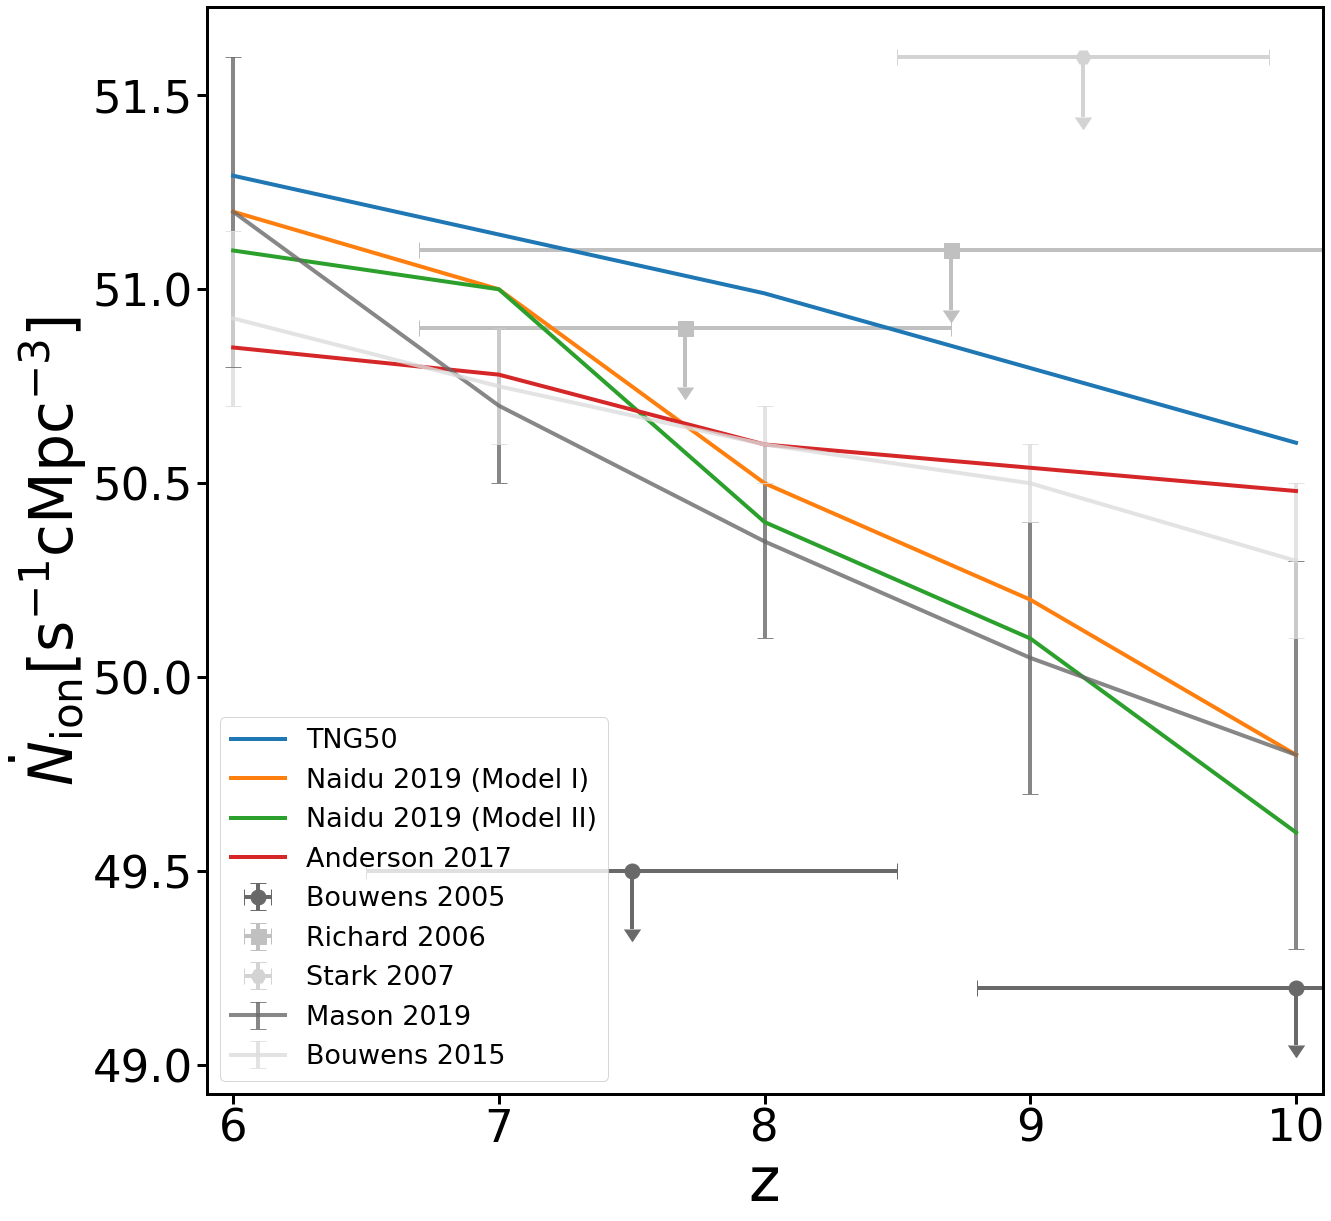

In [47]:
plot_comparisons(comparison, save=True)

In [11]:
comparison['tng']['mode'] = 'tng'
comparison['eide']['mode'] = 'normal'
comparison['bouwens2005']['mode'] = 'limit'
comparison['richard']['mode'] = 'limit'
comparison['stark']['mode'] = 'limit'
comparison['naidu1']['mode'] = 'normal'
comparison['naidu2']['mode'] = 'normal'
comparison['mason']['mode'] = 'shade'
comparison['bouwens']['mode'] = 'shade'
comparison['anderson']['mode'] = 'error shade'

In [12]:
df = pd.read_pickle('dfs/full_esc.pickle')
update_df(df)

In [24]:
df.StarMass.describe()

count    9549.000000
mean        0.003081
std         0.007951
min         0.000100
25%         0.000238
50%         0.000623
75%         0.002202
max         0.145665
Name: StarMass, dtype: float64

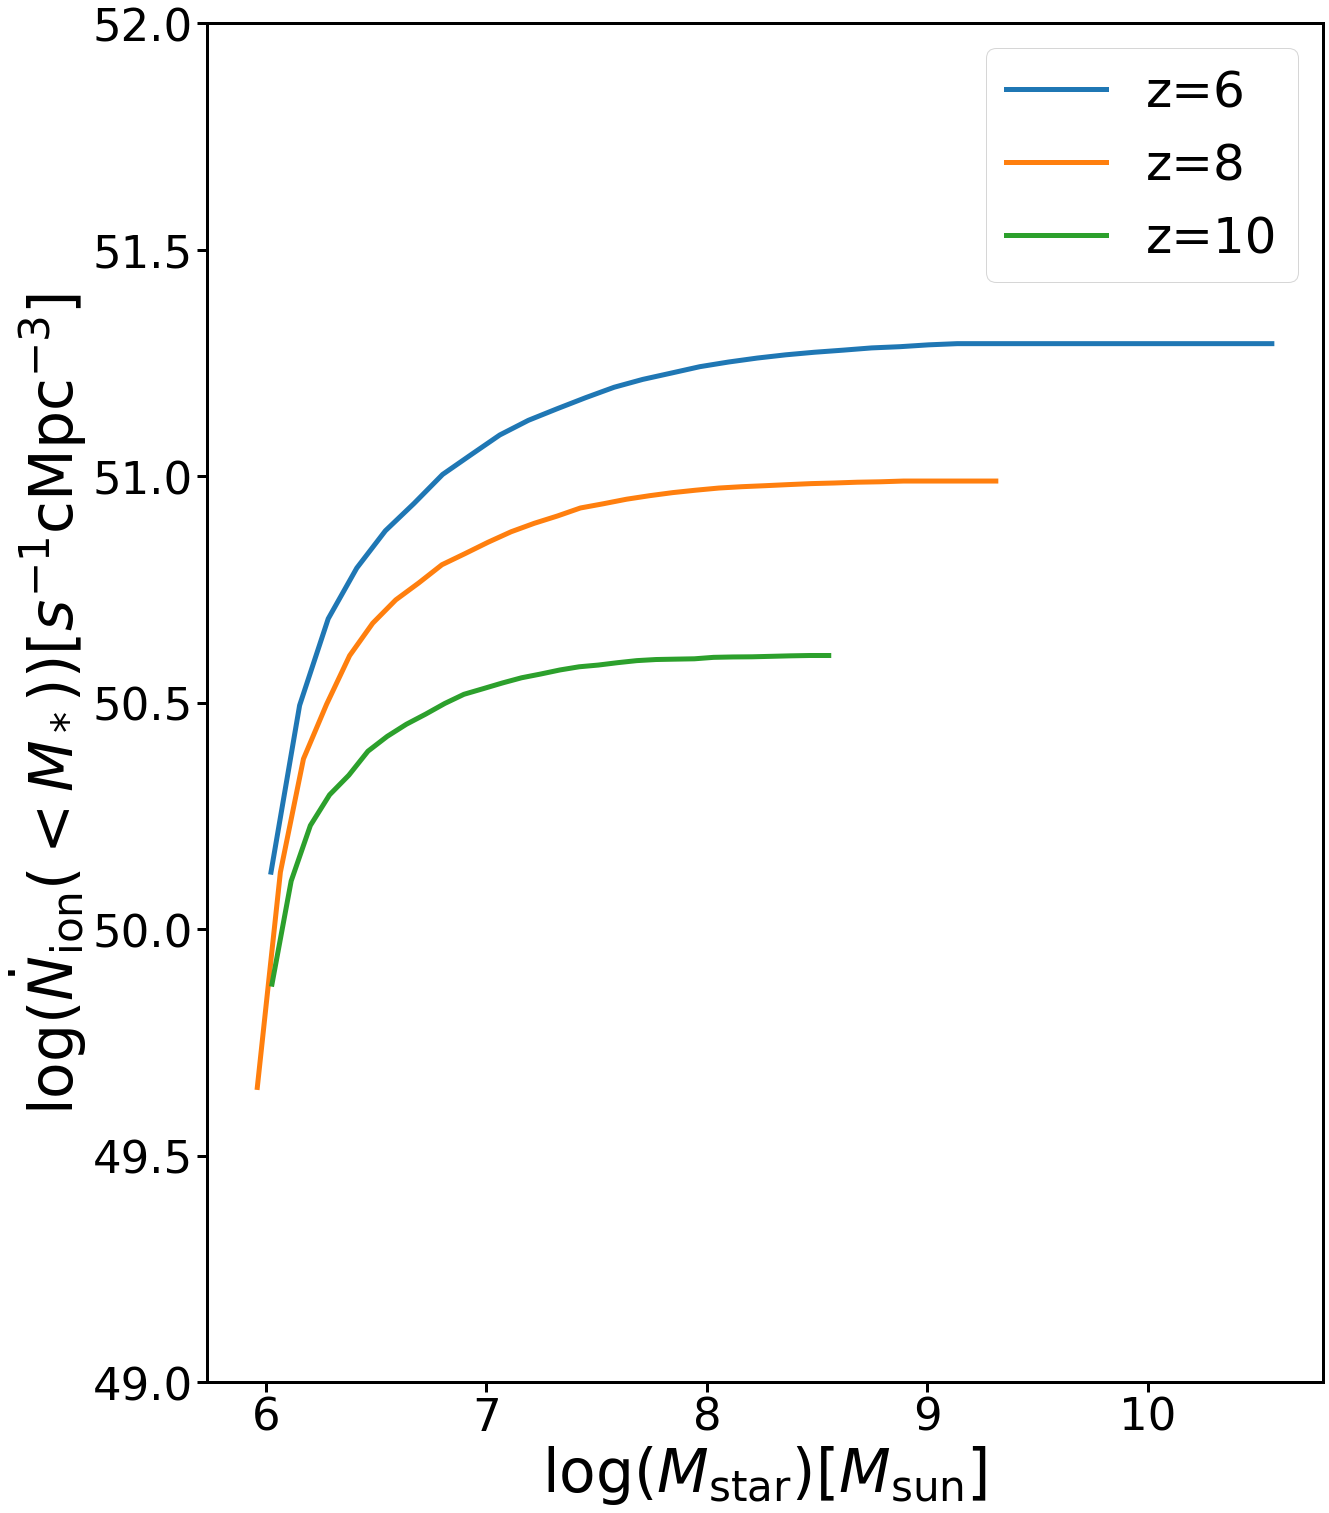

In [53]:
plot_z_esc(df,save=True, mass_type='StarMass', lower_ylim=49, upper_ylim=52, cumulative=True)

[51.29282767 50.98952069 50.60440376]
[0.00389209 0.00782509 0.01899355]


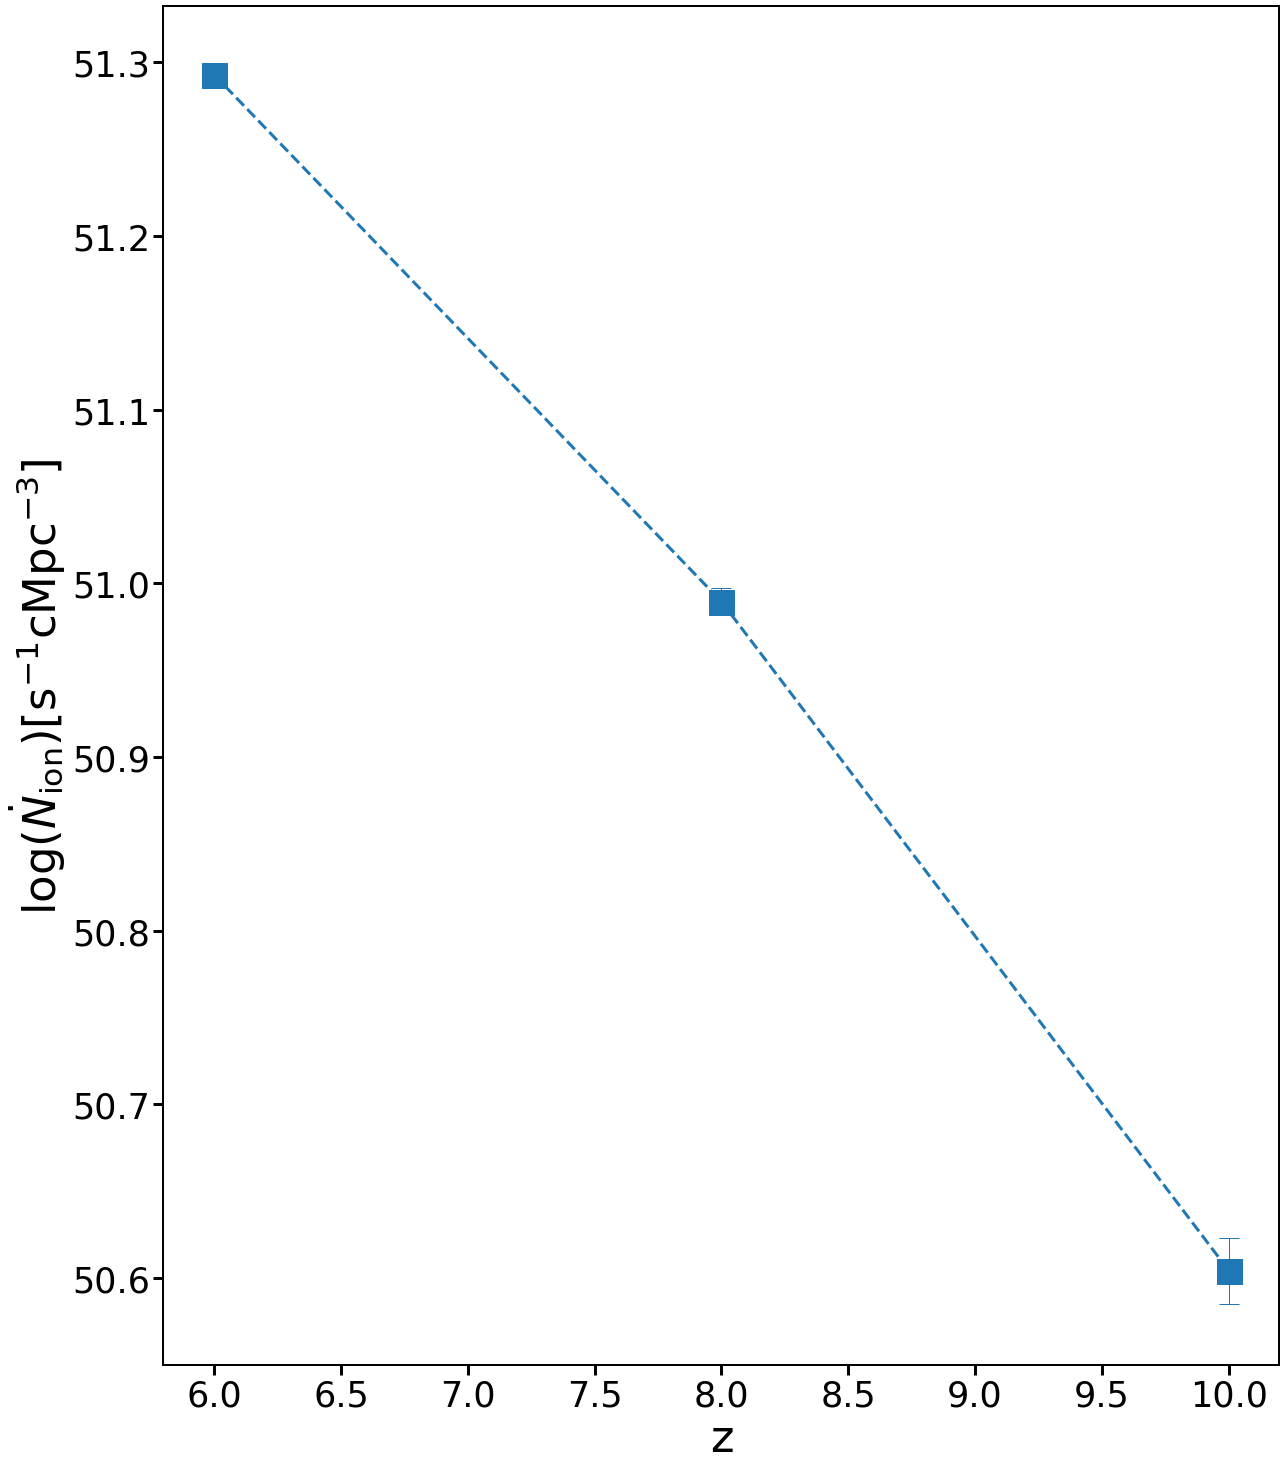

In [25]:
plot_uv_redshift(df, redshifts=[6,8,10], bins=50, mass_type='StarMass', log=True, save=False)